## Standard Imports ##

Since I'm using a dark theme on Google Colab, I manually set some color parameters for plots generated by matplotlib.

In [40]:
#for data ingestion and manipulation 
import numpy as np 
import pandas as pd

#the neural network framework for this project is PyTorch
import torch 
import torch.nn as nn

#custom settings to use with google colab dark theme
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'

# The Model and Data #

The Long Short Term Memory (LSTM) network architecture is a popular choice for forecasting time series. For this project, I want to train a LSTM network to predict the future price of Old School Bonds.

## Data ##
The network will learn to predict future prices from examples of the past price. This data is being scraped from the Old School Runescape Grand Exchange website. 

One disadvantage of collecting data this way is that Jagex only provides a 180 day snapshot of the changing price. Another Python script was written to append new data points to  `old_school_bond_appended.csv.csv` and is available in [the project repository](https://github.com/nurriol2/forecasting).

In [41]:
#get csv with bond data
bond_data = pd.read_csv("https://raw.githubusercontent.com/nurriol2/forecasting/ft-lstm/datasets/old_school_bond_appended.csv")

#check that retrieved the expected data
print(bond_data.head())

   Index Timestamps_close    Close Timestamps_average  Average
0      0       2020/04/08  4134618         2020/04/08  4522980
1      1       2020/04/09  4009639         2020/04/09  4501601
2      2       2020/04/10  3903868         2020/04/10  4473252
3      3       2020/04/11  3853462         2020/04/11  4442300
4      4       2020/04/12  3941327         2020/04/12  4415261


In [42]:
#only want to analyse the daily closing price
close = bond_data["Close"]
close.describe()

count    2.000000e+02
mean     4.427740e+06
std      6.841474e+05
min      3.365424e+06
25%      3.853141e+06
50%      4.339444e+06
75%      4.959934e+06
max      5.934796e+06
Name: Close, dtype: float64

In [43]:
def create_sequences(dataset, seq_len):
    """Generate input sequences with specified length from a dataset

    Args:
        dataset (pandas.Series):  The time series to create sequences from. It is 
                                    assumed that the Series is ordered such that the
                                    most recent measurement is the last record.
        
        seq_len (int):  The number of elements in a sequence
    
    Returns: 
        (xs, ys):  A tuple of numpy arrays ordered like (input sequence, true label)
    """

    xs = []
    ys = []

    for i in range(len(dataset)-seq_len):
        xs.append(dataset[i:i+seq_len])
        ys.append(dataset[i+seq_len])
        
    return np.asarray(xs), np.asarray(ys)  

In [44]:
#define a train-test split ratio
train_size = int(len(bond_data)*.70)

#slice out the training data
training_data = close[:train_size].to_numpy()
#slice out the test data 
test_data = close[train_size:].to_numpy()

# Scaling #

In order to avoid data leaking, it's important to create the training and testing sequences *before* scaling and translating. Here, we translate the test set to the scale set by the training set.

## An Example of Data Leaking##

Let's consider what happens with this simple data set:    
`[0, 2, 5, ,8, 3, 10]`

If points are scaled according to the minimum and maximum of the entire dataset, our scaled data looks like  
`[0.0, 0.2, 0.5, 0.8, 0.3, 1.0]`

Now we (mistakenly) split into training and testing  

`training = [0.0, 0.2, 0.5, 0.8]`  
`testing = [0.3, 1.0]`

Testing data is meant to help the data scientist measure the performance of the model on *new* data-stuff the model hasn't seen before!

But the model had some information about this unseen test set! The training data was influenced by including the test points in the scaling step.

We say this that data *leaked* into the training set. Specifically, information about the maximum value of the whole data set is inherently present in the training set.


In [45]:
class CustomScaler:

    def __init__(self, dmin, dmax):
        self.dmin = dmin
        self.dmax = dmax
        return

    def fit_transform(self, array):
        return (array - self.dmin)/(self.dmax - self.dmin)

    def inverse_transform(self, array):
        return (array*(self.dmax - self.dmin) + self.dmin)

In [46]:
def scale_array(scaler_obj, array):
    """
    Scale an array according to a scaler object, then convert the array to 
    a PyTorch tensor.

    Args:
    scaler_obj (sklearn Scaler):  The scaler object from SciKitLearn that defines
    the scaling transform

    array (numpy.ndarray):  An array of the data to be transformed

    Returns:
    (torch.Tensor):  PyTorch Tensor representation of the scaled array
    """

    #the same as array, after being transformed by the scaler_obj
    scaled_array = None

    #check that the dataset array is 2 dimensional
    if array.ndim==2:
        #scaled dataset array
        scaled_array = scaler_obj.fit_transform(array)
    #the dataset is not 2 dimensional
    else:
        #reshape the data 
        array = array.reshape(-1, 1)
        #return scaled data
        scaled_array = scaler_obj.fit_transform(array)

    scaled_tensor = torch.from_numpy(scaled_array).float()

    return scaled_tensor


#instance of a CustomScaler to use in `scale_array` method
train_min = training_data.min()
train_max = training_data.max()
scaler = CustomScaler(train_min, train_max)

#apply scaling to the training and test data
training_data = scale_array(scaler, training_data).flatten().numpy()
test_data = scale_array(scaler, test_data).flatten().numpy()


In [47]:
#visually check the data has been scaled
training_data

array([0.49072704, 0.41099346, 0.34351414, 0.31135634, 0.3674121 ,
       0.42692629, 0.41374123, 0.3509    , 0.2408492 , 0.13450377,
       0.1483861 , 0.1875693 , 0.25836036, 0.3171919 , 0.37074232,
       0.35367262, 0.31053782, 0.24804492, 0.20564634, 0.2252105 ,
       0.23645481, 0.2224755 , 0.19984268, 0.23384677, 0.23847274,
       0.19280261, 0.15359391, 0.10567811, 0.14171672, 0.17432046,
       0.17836076, 0.11920192, 0.10919208, 0.17646024, 0.24436316,
       0.30175608, 0.27013546, 0.20813316, 0.17544521, 0.10184579,
       0.07214037, 0.07521733, 0.08834112, 0.08852103, 0.07439115,
       0.04482034, 0.        , 0.0401797 , 0.04862076, 0.11993623,
       0.15079574, 0.12839706, 0.09159097, 0.08292152, 0.12360013,
       0.17972475, 0.23931614, 0.32744226, 0.36430067, 0.3294557 ,
       0.2432818 , 0.22253929, 0.25940472, 0.29576677, 0.3309269 ,
       0.34118935, 0.34266436, 0.33694747, 0.38173592, 0.39545685,
       0.43121603, 0.47326052, 0.49355006, 0.42161193, 0.36476

In [48]:
#visually check the data has been scaled
test_data

array([0.94967204, 0.9940439 , 0.9691041 , 0.91064835, 0.92438203,
       0.9977275 , 1.0658263 , 1.0750113 , 1.1005437 , 1.0631073 ,
       1.0176541 , 1.0216912 , 1.0621363 , 1.1179559 , 1.1822027 ,
       1.219967  , 1.1362352 , 1.017127  , 0.9444049 , 1.0040798 ,
       1.1363584 , 1.2271755 , 1.2464027 , 1.1932268 , 1.1607679 ,
       1.1335232 , 1.1321375 , 1.1735977 , 1.2076764 , 1.2009413 ,
       1.152288  , 1.0277296 , 0.99437815, 1.0815735 , 1.1847565 ,
       1.2578244 , 1.266973  , 1.2886572 , 1.262497  , 1.2414017 ,
       1.271719  , 1.3935889 , 1.4357201 , 1.4641126 , 1.4443449 ,
       1.3397086 , 1.2877289 , 1.3381329 , 1.4368532 , 1.5519835 ,
       1.6044979 , 1.5306017 , 1.4415053 , 1.3995086 , 1.4472331 ,
       1.5554024 , 1.6391968 , 1.6277201 , 1.5083671 , 1.4144487 ],
      dtype=float32)

In [49]:
#the number of data points in an input sequence
seq_len = 5

#finally create the training and test sequences
X_train, y_train = create_sequences(training_data, seq_len)
#(number of sequences, length of sequences), (number of predicted values)
print(X_train.shape, y_train.shape)

X_test, y_test = create_sequences(test_data, seq_len)
print(X_test.shape, y_test.shape)

(135, 5) (135,)
(55, 5) (55,)


# Setting a Baseline #

It's time to start thinking about the models that will work with the data.

LSTMs can take some time to fully understand and appreciate. Even though this project is supposed to be educational, I still want  way to justify using LSTMs over something else.

Consider this same problem in a business setting, where time, labor, and maitenance come with a price tag. When deciding between two models with equivalent performance, the responsible choice is to use the one that is faster to build and easier to maintain in the future.

In both cases, there needs to be some sort of baseline. A baseline is just a model that is simple to build and performs reasonably.

The baseline for this project will be a Mean Model. A Mean Model is a model that always predicts the mean (average) of the input sequence. Changing the size of the input sequence, can change the prediction.

By defining a baseline with the Mean Model, I can say whether the more complicated LSTM model is worth using "in production" by comparing the two models.

In [50]:
class MeanModel(nn.Module):

    def __init__(self):
        super(MeanModel, self).__init__()
        return

    def forward(self, x):
        return torch.mean(x)

# Shaping Data for the Mean Model #

In the class above, it's important to note that the MeanModel works with tensors. So, the training/test sets need to be converted to tensors.

In this section, we will see how the mean model performs on the training and test sets separately.


In [51]:
#convert everything to tensors
X_train_mm = torch.from_numpy(X_train)
y_train_mm = torch.from_numpy(y_train)

X_test_mm = torch.from_numpy(X_test)
y_test_mm = torch.from_numpy(y_test)

In [52]:
#reshape the labels to be column vectors
y_train_mm = y_train_mm.view(-1, 1)
y_test_mm = y_test_mm.view(-1, 1)

In [53]:
y_train_mm.shape, y_test_mm.shape #the data is ready to work with the Mean Model

(torch.Size([135, 1]), torch.Size([55, 1]))

# Making Predictions with the Mean Model #



In [54]:
#instance of the mean model
meanmodel = MeanModel()

In [55]:
def mean_model_predictions(model, X):
    """Make predictions using a Mean Model

    Args:
    model (MeanModel):  An instance of a MeanModel
    X (torch.Tensor):  Input sequences  
    """
    #store predictions as a list
    mean_preds = []
    #iterate over the input
    for sequence in X:
        #actual prediction step
        pred = model(sequence)
        #update the list
        mean_preds.append(pred)

    #convert mean list to tensor
    mean_preds = torch.FloatTensor(mean_preds)

    return mean_preds

I will often want to visually inspect the model's predictions with the true data. So, here's a simple function that plots the two series together.

In [56]:
def plot_predictions_with_truth(predicted_price, true_price, title):
    """Plot the predicted price and true price series together.
    Note:  This method does not perform any checks for concurrency or for scaling.

    Args:
    predicted_price (numpy.ndarray):  The predictions made by the model
    true_price (np.ndarray):  The true price series 
    """

    plt.plot(predicted_price, "darkorange", label="Model Prediction")
    plt.plot(true_price, "cornflowerblue", label="True Price")
    plt.title(title)
    plt.legend()
    plt.show()
    return 

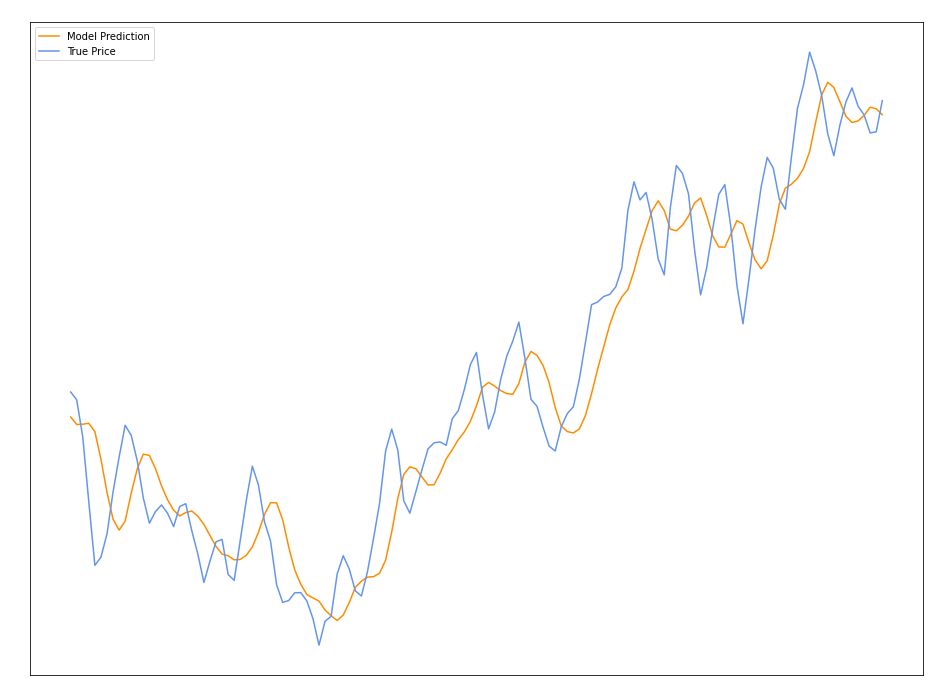

In [57]:
mean_train_preds = mean_model_predictions(meanmodel, X_train_mm)

#inverse transform the scaled predictions 
true_train_price = scaler.inverse_transform(y_train.flatten())
predicted_train_price = scaler.inverse_transform(np.expand_dims(mean_train_preds, axis=0)).flatten()

plot_predictions_with_truth(predicted_train_price, true_train_price, "Mean Model - Training Data Prediction")

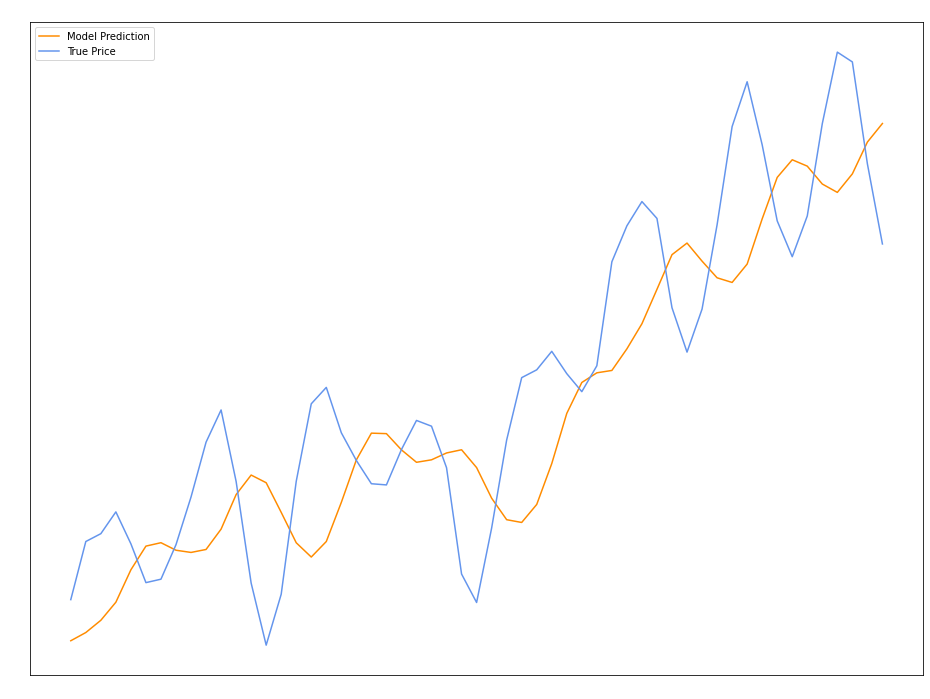

In [58]:
mean_test_preds = mean_model_predictions(meanmodel, X_test_mm)

#inverse transform the scaled predictions 
true_test_price = scaler.inverse_transform(y_test.flatten())
predicted_test_price = scaler.inverse_transform(np.expand_dims(mean_test_preds, axis=0)).flatten()

plot_predictions_with_truth(predicted_test_price, true_test_price, "Mean Model - Test Data Prediction")

___

# Shaping Data for the LSTM #

Now I'll work on the LSTM.

Just like the Mean Model, the LSTM network expects input with a specific shape.
I prepare the training and test set tensors in the next step to match the expected input. 

You will notice that the training and test sets are 3 dimensional. Let's understand this `X_train.shape = (135, 5, 1)`:

The first dimension is the number of total input sequences. In this case, there are 135 input sequences in the training set.

The second dimension is the number of elements in each sequence. For this experiment, I chose 5 elements. This choice corresponds to the closing price for bonds on 5 consecutive days. 

The final dimension wraps all of these sequences. 

For a simpler example, a tensor with shape (2, 3, 1) would look like this: 

[
    [1,2,3],
    [4,5,6]
]



In [59]:
#reshape training and test data 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], 1)
#expected shapes:
#X_... -> (number of total sequences, number of elements in a single sequence, 1)
#y_... -> (number of labels, 1)
print(X_train.shape, y_train.shape)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
print(X_test.shape, y_test.shape) #the shapes match expectations

(135, 5, 1) (135, 1)
(55, 5, 1) (55, 1)


In [60]:
#the LSTM class will work with tensors
X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# The LSTM #

An excellent explanation of LSTM networks can be found on [Christopher Olah's Blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). I highly recommend reading their post.

Below is an image of an LSTM cell at an arbitrary time step *t*. The main idea is that at each time step, the LSTM cell produces an updated *cell state* and *hidden state* based on input recieved from the previous LSTM cell. 

## PyTorch to the Rescue ##

The 6 equations in the diagram are the machinery of the LSTM network. PyTorch provides the `LSTM` class which handles these calculations, provided the input $x_{t}$ is shaped correctly. 

To learn more about the gate operations, hidden states, and cell states I recommend reading Christopher Olah's post.

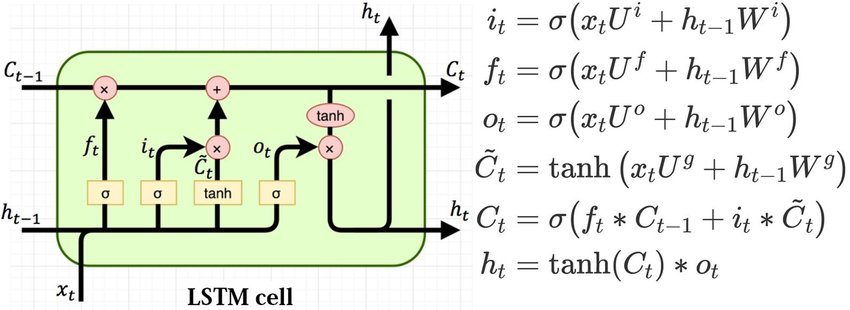

# Model Parameters #

The `LSTM` class has a parameter `num_layers` which is used to create *Stacked LSTMs*. The idea is that several LSTM cells are stacked together. The outputs of one cell become the input for the next. In future iterations of this project, we will see experiments where the `num_layers` is changed to see how it affects performance.

In [61]:
#(LSTM cells)
#number of expected features in input (X)
input_dim = 1
#number of hidden features in hidden state
hidden_dim = 216
#number of LSTM cells to stack
num_layers = 2

#(fully connected layer)
#number of output labels (y)
output_dim = 1

In [62]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        #neurons in a hidden layer
        self.hidden_dim = hidden_dim
        #number of hidden layers
        self.num_layers = num_layers

        #module that handles applying the gates and point operations
        #LSTM takes in sequences and outputs hidden states
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        #(fully connected) 
        #maps from hidden state space to output space
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        #iniital hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        #initial cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        #vectors have passed through gates and operations
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        #grab the latest time step
        out = self.fc(out[:, -1, :]) 
        return out

In [63]:
#instantiate the model
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

#MSE is a typical choice in regression problems
loss_fn = torch.nn.MSELoss(reduction="mean")

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

#the types of layers that constitute the network
print(model)
#the number of tensors with learnable parameters (elements)
print(len(list(model.parameters())))

LSTM(
  (lstm): LSTM(1, 216, num_layers=2, batch_first=True)
  (fc): Linear(in_features=216, out_features=1, bias=True)
)
10


In [64]:
num_epochs = 60 

In [65]:
#record the training loss at each epoch
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(X_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.00975946057587862
Epoch  20 MSE:  0.013599058613181114
Epoch  30 MSE:  0.008151642046868801
Epoch  40 MSE:  0.007657201029360294
Epoch  50 MSE:  0.006256365682929754


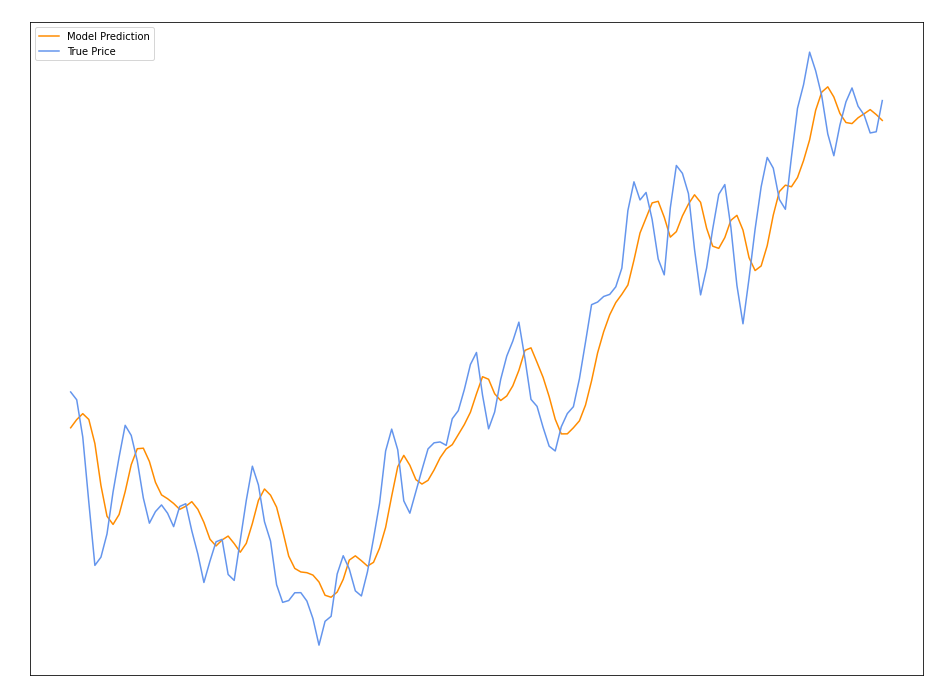

In [66]:
lstm_train_preds = scaler.inverse_transform(y_train_pred).detach().numpy()
train_truth = scaler.inverse_transform(y_train).detach().numpy()
plot_predictions_with_truth(lstm_train_preds, train_truth, "LSTM - Training Data Prediction")

# Training Loss #
One way to monitor how the model is learning is to measure its loss after each epoch.

The loss I'm using here is the Mean Squared Error (MSE). This is a typical choice for a loss function in regression problems.

To learn more about MSE, I recommend watching [ritvikmath's videon on loss functions]()

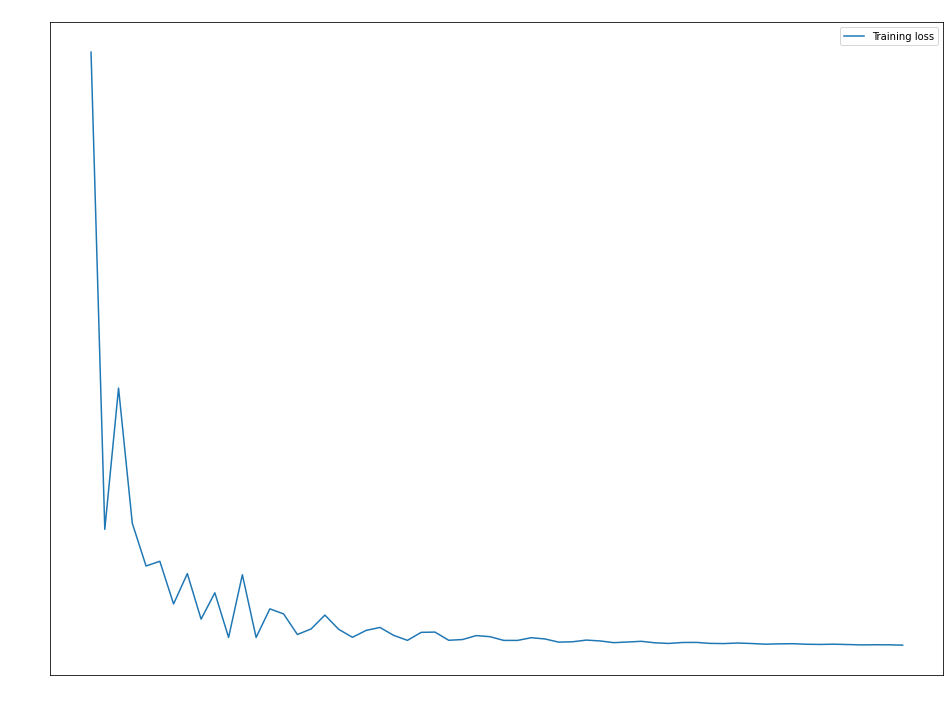

In [67]:
plt.plot(hist, label="Training loss")
plt.title("LSTM Model Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

# Is the LSTM Worth it? #
Now is a good time to compare to the baseline. I'll do this with a simple plot.

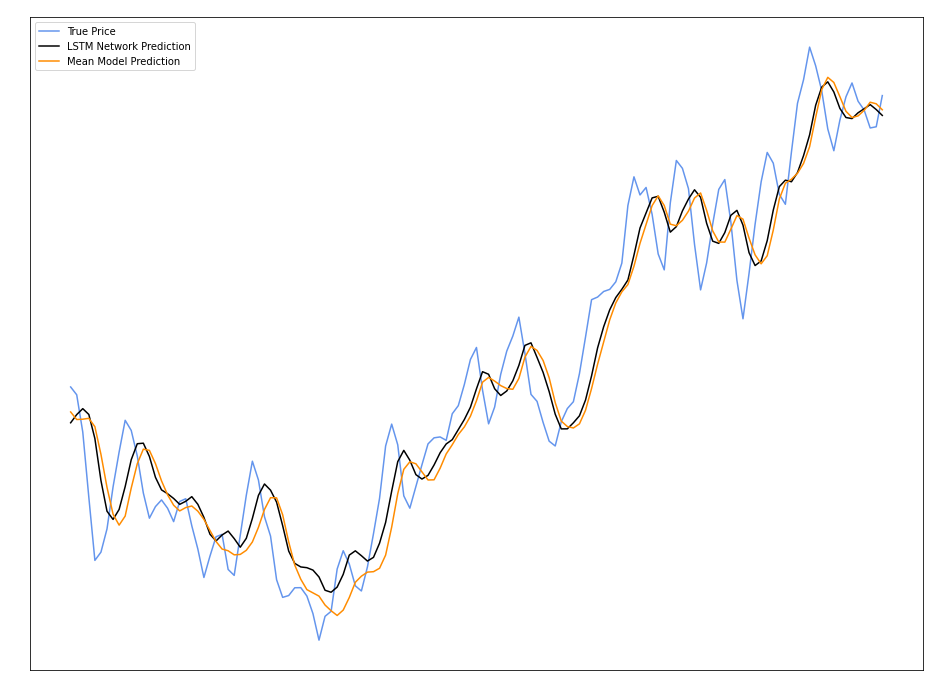

In [68]:
plt.plot(true_train_price, "cornflowerblue", label="True Price")
plt.plot(lstm_train_preds, "k", label="LSTM Network Prediction")
plt.plot(predicted_train_price, "darkorange", label="Mean Model Prediction")
plt.legend()
plt.show()

From this plot, I notice that the LSTM has essentially learned the 5 day mean since the LSTM predictions follow the Mean Model Predictions.

However, the LSTM is slightly closer to the true price. This behavior means that price swings are prediccted slightly sooner with the LSTM network than the Mean Model. 

I could quantify the advantage of predicting price swings sooner, however I think the difference here is too small to warrant that investigation right now. Maybe in another chapter of this project.

As for now, there is little reason to use the LSTM over the Mean Model. Let's see continue to the test set. 



# Making Predictions with the LSTM Network #

I will tackle hyperparameter tuning in another chapter of this ongoing project.

For now, I will assume that I am satisfied with the LSTM's performance on the training data and no further tuning is needed.

Now it's time to see how well the model predicts the test data.

In [69]:
#make predictions with the LSTM
y_test_pred = model(X_test)
y_test_pred[:10] #see in the output that these predictions need to be inverse scaled

tensor([[0.9567],
        [0.9701],
        [0.9915],
        [1.0130],
        [1.0457],
        [1.0593],
        [1.0559],
        [1.0487],
        [1.0492],
        [1.0593]], grad_fn=<SliceBackward>)

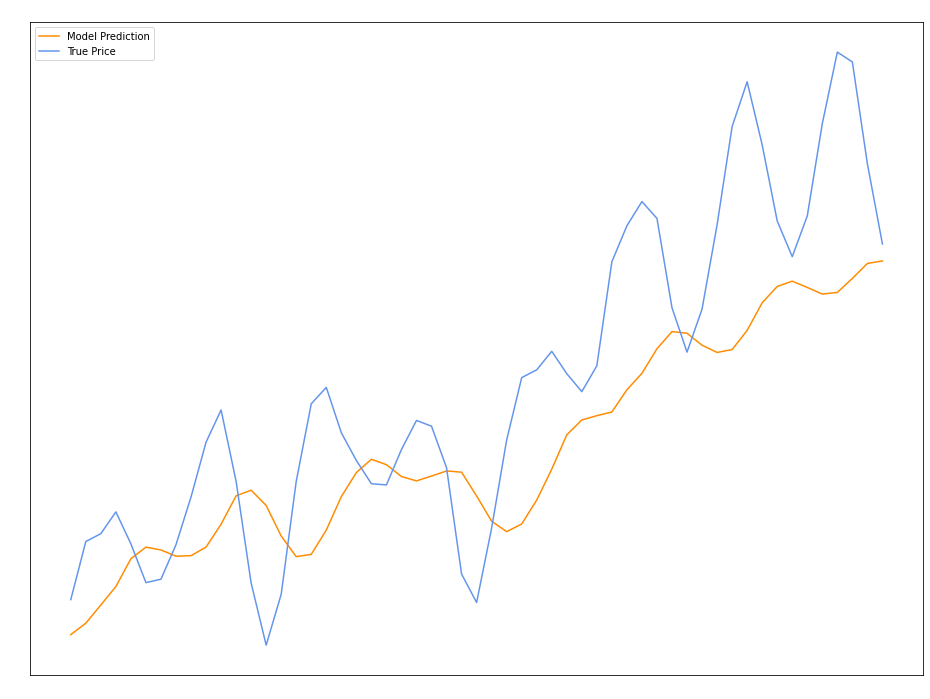

In [70]:
#unscale and plot predictions with the truth 
y_test_pred = scaler.inverse_transform(y_test_pred).detach().numpy()
test_truth = scaler.inverse_transform(y_test).detach().numpy()

plot_predictions_with_truth(y_test_pred, test_truth, "LSTM - Test Data Predictions")

Once again, it's useful to compare to the Mean Model and check if its worth using the LSTM "in production".

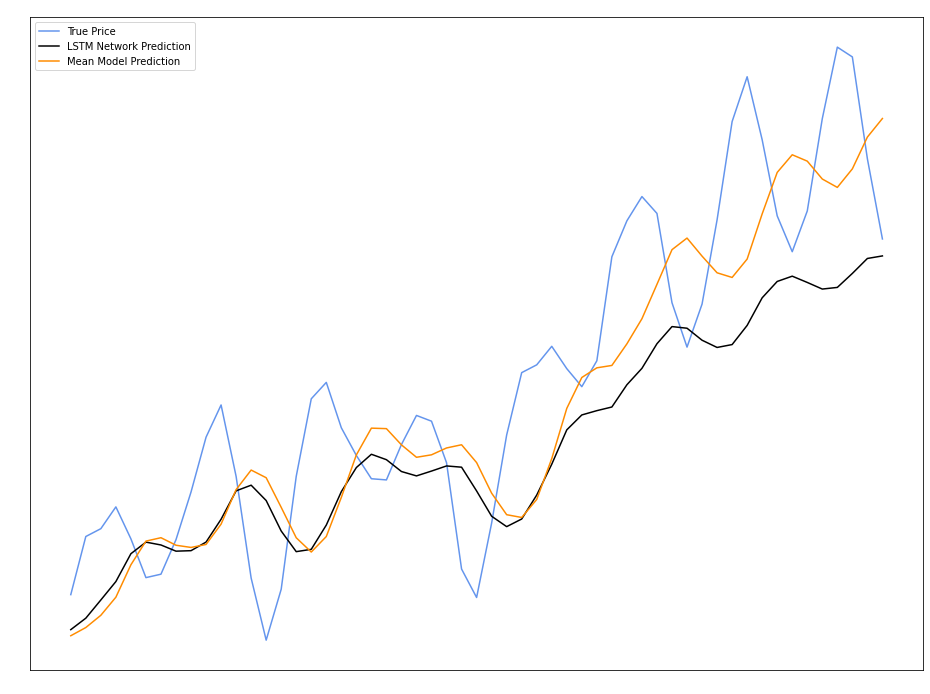

In [82]:
plt.plot(true_test_price, "cornflowerblue", label="True Price")
plt.plot(scaler.inverse_transform(y_test_pred), "k", label="LSTM Network Prediction")
plt.plot(predicted_test_price, "darkorange", label="Mean Model Prediction")
plt.legend()
plt.show()

I notice here that as more days pass, the LSTM predictions are diverging from both the true price and the Mean Model predictions. This might be, yet another, sign that building an LSTM from scratch is not worth using "in production".

# A Full History #

Below I take a look at the LSTM predictions together and the true price data.

In [71]:
x = np.arange(len(y_train), len(y_train)+len(y_test))
x = np.reshape(x, (-1, 1))
y_test_pred = scaler.fit_transform(y_test_pred)

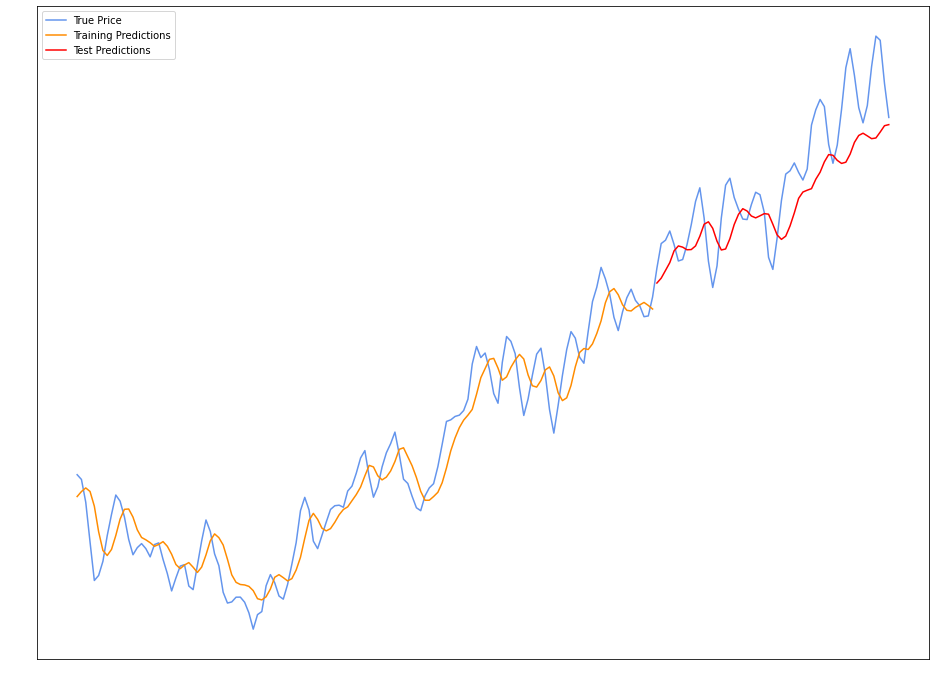

In [72]:
all_truth = torch.cat((y_train, y_test), 0)
plt.plot(all_truth, "cornflowerblue", label="True Price")
plt.plot(y_train_pred.detach().numpy(), "darkorange", label="Training Predictions")
plt.plot(x, y_test_pred, "red", label="Test Predictions")
plt.legend()

___
# Conclusion #
Building a LSTM network from scratch does not provide many significant advantages over a Mean Model. The Mean Model is clearly easier to explain and maintain with changing data. That is to say, flattening incoming data is easier than creating and shaping sequences.

Some high performing deep learning models are trained on millions or billions of data points. In this project, I have only 200 data points to use. In cases where data is scarce (or maybe very expensive to get a hold of), the researcher needs to be creative with how they approach the problem. None of these techniques were used here because this chapter was for educational purposes.

After doing this project, I have a basic understanding of how LSTM networks are used to forecast on time series data. I also think this project gave me the opportunity to learn how to create models with PyTorch. Most importantly, concluding this chapter gives me a launching point for future improvements on tackling this problem. One should expect a mix of educational chapters and product focused chapters, in the future. 

I did not try using PyTorch `DataLoaders`, however. I was able to load in and ingest my data into the models here, but using `DataLoaders` are imperative for taking full advantage of the PyTorch library. Especially when it comes to using pre-trained models. The GADF transform, for example, will rely on using a pre-trained image classifying model to make predictions on time series. It will be a fun experiment to try and use `DataLoaders` there.

___
# Topics to Cover in Future Chapters #

## Predicting Beyond the Datasets ##
So far, I have restricted myself to making predictions on the same timescale as the historical data. With future iterations of this project, I'll add the ability to forecst beyond the data set. 

To do this, I need to create input sequences from the predictions made by the model. 

## Hyperparameter Tuning ##
As mentioned before, I explicitly skipped hyperparameter tuning. PyTorch suggests using the [Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) to tune models. 

Future additions of this project will focus on learning to tune models using Ray Tune. 

## Differenced Data ##
If you follow this project series, you might remember the Fourier Forecast.

In that chapter, I postulated that the *first differenced data* might be better suited to use the Fourier forecasting technique. Specifically, instead of analysing the historical price data iteself what if I tried forecasting the size and direction of the dailiy price change.

I think something similar could be done in future iterations of this project. I could investigate if there are significant advantages to using an LSTM network to predict the price change, instead of the price itself.

## GADF Technique ##
I got this idea from FastAI's course on [Practical Deep Learning](https://colab.research.google.com/drive/1Ltt2LaQI9kzC04HhLjAZpPNPO8WbVRGE#scrollTo=MwmCxtZQNujI). In the first chapter, the authors discuss how I. Oguiza used the Gramian Angular Difference Field technique to make images from their time series. These images were then fed into image classifying neural networks and the resulting classifications were used to make predictions on time series. Oguiza achieved remarkable accuracy with just a few hundred time series.

There seem to be a healthy number of pacckages and projects on GitHub that try to implement this same pipeline, so I hope to be able to try it out myself.